In [1]:
from homography import pyrs12, spaces
import os, cv2, h5py, random, string
import numpy as np
import HandShapeAnalysis
import matplotlib.pyplot as plt
import deproject
from functools import reduce
import pptk
from importlib import reload
reload(HandShapeAnalysis)

<module 'HandShapeAnalysis' from 'E:\\User\\workspace\\multi-touch\\notebook\\HandShapeAnalysis.py'>

In [2]:
# def depth2cloud(image, mat, org, show = False):
#     cloud = deproject.compute(image.astype(np.short()))
#     point_original = (np.dot(mat, (cloud - org).reshape((-1,3)).T).T)
#     # if show: plt.imshow(point[image != 0].reshape((-1,3)))
#     return point_original#, point[without_table].reshape((-1,3))
# data = !ls -d ../experiement/recording/*/*.hdf5
# for i in data:
#     h5f = h5py.File(i, 'r')
#     depth_frame = h5f['depth'][...]
#     pcl_center = h5f['pcl_center'][...]
#     trans_matrix = h5f['trans_matrix'][...]
#     print(i)
#     for j in range(len(depth_frame)):
#         print(j)
#         CLOUD = depth2cloud(depth_frame[j], trans_matrix,pcl_center)
#         CLOUD = np.where(((CLOUD[:,2]>=0.01) & (depth_frame[j].reshape(-1) != 0)).reshape(-1,1), CLOUD, np.zeros(3,)).reshape(480,640,3)[:,:,2]
#         CLOUD = np.where(CLOUD>0,1,0)
#         plt.imshow(CLOUD)
#         plt.show()
#     h5f.close()

In [3]:
!dir "../recording_data/2_tap.hdf5"

 磁碟區 E 中的磁碟是 3TB
 磁碟區序號:  9C7D-7AEC

 E:\User\workspace\multi-touch\recording_data 的目錄

04/12/2018  13:43        34,380,495 2_tap.hdf5
               1 個檔案      34,380,495 位元組
               0 個目錄  3,064,196,362,240 位元組可用


In [4]:
data

NameError: name 'data' is not defined

In [5]:
h5f = h5py.File("../recording_data/2_tap.hdf5", 'r')
depth_frame = h5f['depth'][...]
pcl_center = h5f['pcl_center'][...]
trans_matrix = h5f['trans_matrix'][...]

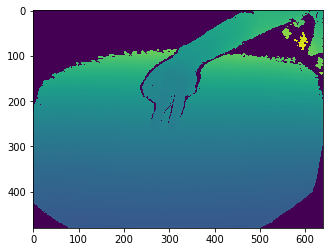

In [6]:
plt.imshow(depth_frame[13])

In [9]:
depth_frame[13].dtype

dtype('uint16')

In [10]:
print("%d bytes" % (CLOUD.size * CLOUD.itemsize))

3686400 bytes


In [11]:
CLOUD.dtype

dtype('float32')

In [12]:
print("%d bytes" % (depth_frame[13].size * depth_frame[13].itemsize))

614400 bytes


Point Cloud

In [13]:
pptk.viewer(CLOUD)

Homography transform

In [14]:
CLOUD = (np.dot(trans_matrix, (CLOUD - pcl_center).reshape((-1,3)).T).T)

In [15]:
pptk.viewer(CLOUD)

In [19]:
pptk.viewer(CLOUD[CLOUD[:,0]>0.04])

In [106]:
# v = pptk.viewer(CLOUD)
# v.wait()

In [128]:
# from numpy.polynomial.polynomial import polyfit
# fig = plt.figure()
# part_of_CLOUD = CLOUD[v.get('selected')]
# plt.plot(part_of_CLOUD[:,1], part_of_CLOUD[:,2], 'ro', label='Point', alpha=0.03)


# b, m = polyfit(part_of_CLOUD[:,1], part_of_CLOUD[:,2], 1)

# plt.plot(part_of_CLOUD[:,1], b + m * part_of_CLOUD[:,1], label='Regression line', linestyle='--')
# plt.ylim(0, 0.01)
# plt.xlim(np.min(part_of_CLOUD[:,1]),np.max(part_of_CLOUD[:,1]))
# fig.suptitle('Subset that contain 333 point from point cloud')
# plt.xlabel('y-axis value')
# plt.ylabel('z-axis value')
# plt.legend(loc='upper right')
# fig.savefig("waved_surface.pdf")

Minimum filter

In [57]:
filtered = CLOUD[CLOUD[:,2]>=0.01]
filtered = filtered[filtered[:,2]<0.2]

In [58]:
pptk.viewer(filtered)

In [18]:
all_color = np.full(CLOUD[CLOUD[:,2]<0.01].shape, 255)
selectcolor = np.full(CLOUD[CLOUD[:,2]>=0.01].shape, 0)
selectcolor[:,0]=255

In [59]:
v = pptk.viewer(np.concatenate((CLOUD[CLOUD[:,2]<0.01], CLOUD[CLOUD[:,2]>=0.01])),np.concatenate((all_color, selectcolor)))
v.set(point_size=0.0001)

minimun along y axis

In [20]:
min_point = filtered[np.argmax(filtered[:,1])]
v = pptk.viewer(filtered)
v.play([[min_point[0], min_point[1], min_point[2], 1 * np.pi/2, np.pi/4, 0.5]])
v.set(point_size=0.0001)

area

In [18]:
from scipy.spatial import ckdtree

In [19]:
tree = ckdtree.cKDTree(CLOUD)

In [20]:
bool_fiter_neighbours = tree.query_ball_point(min_point, r=0.02)

In [29]:
mask = np.ones(len(CLOUD), np.bool)
mask[bool_fiter_neighbours] = 0

In [30]:
selected_area = CLOUD[bool_fiter_neighbours]
not_selected_area = CLOUD[mask]
pptk.viewer(not_selected_area)

In [31]:
all_color = np.full(not_selected_area.shape, 255)
selectcolor = np.full(selected_area.shape, 0)
selectcolor[:,0]=255

In [33]:
pptk.viewer(np.concatenate((not_selected_area, selected_area)),np.concatenate((all_color, selectcolor)))

Feature Extraction

In [55]:
pptk.viewer(selected_area)

In [67]:
hist, bins = np.histogram(selected_area[:,2],
                              bins=20,
                              range=(-0.01, 0.06),
                              density=1)

In [68]:
bins

array([-0.01  , -0.0065, -0.003 ,  0.0005,  0.004 ,  0.0075,  0.011 ,
        0.0145,  0.018 ,  0.0215,  0.025 ,  0.0285,  0.032 ,  0.0355,
        0.039 ,  0.0425,  0.046 ,  0.0495,  0.053 ,  0.0565,  0.06  ],
      dtype=float32)

Text(0, 0.5, 'Accumulate')

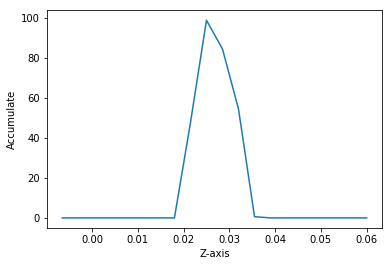

In [69]:
plt.plot(bins[1:],hist)
plt.xlabel("Z-axis")
plt.ylabel("Accumulate")

defect

In [70]:
all_color = np.full(CLOUD.shape, 255)
selectcolor = np.full(CLOUD[CLOUD[:,2]>=0.02].shape, 0)
selectcolor[:,0]=255

In [71]:
pptk.viewer(np.concatenate((CLOUD, CLOUD[CLOUD[:,2]>=0.02])),np.concatenate((all_color, selectcolor)))

Random sample consensus surface filting

In [162]:
from HandShapeAnalysis import filter_by_ransac

In [163]:
zCLOUD = np.where(CLOUD[:,2]>=0, CLOUD[:,2],np.zeros(shape=CLOUD.shape[0:-1]))
CLOUD[:,2] = zCLOUD

filter_= filter_by_ransac(CLOUD,threshold = 2.7e-3, iterations = 1000)[0]
filtered = CLOUD[filter_]
# pptk.viewer(filtered)
mask = np.ones(len(CLOUD), np.bool)
mask[filter_] = 0

selected_area = CLOUD[filter_]
not_selected_area = CLOUD[mask]

E:\User\workspace\multi-touch\notebook\HandShapeAnalysis.py:632: RuntimeWarning: invalid value encountered in true_divide
  normal_vector_normalised = np.divide(normal_vector, np.linalg.norm(normal_vector))
E:\User\workspace\multi-touch\notebook\HandShapeAnalysis.py:637: RuntimeWarning: invalid value encountered in less_equal
  inliers = distances <= threshold
E:\ProgramFiles\anaconda\lib\site-packages\numpy\core\numeric.py:1779: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
E:\ProgramFiles\anaconda\lib\site-packages\numpy\core\numeric.py:1776: RuntimeWarning: invalid value encountered in subtract
  cp0 -= tmp
E:\ProgramFiles\anaconda\lib\site-packages\numpy\core\numeric.py:1782: RuntimeWarning: invalid value encountered in subtract
  cp2 -= tmp
E:\User\workspace\multi-touch\notebook\HandShapeAnalysis.py:628: RuntimeWarning: invalid value encountered in subtract
  centre_point1_vector = np.subtract(n_points[1], center)
E:\ProgramFiles\anaconda\lib\site-packages\num

In [315]:
all_color = np.full(not_selected_area.shape, 255)
selectcolor = np.full(selected_area.shape, 0)
selectcolor[:,0]=255

In [143]:
v = pptk.viewer(np.concatenate((selected_area, not_selected_area)),np.concatenate((selectcolor,all_color)))
v.set(point_size=0.0001)

NameError: name 'selected_area' is not defined

apply point cloud filter on depth image

In [318]:
depth_frame[13].dtype

dtype('uint16')

In [164]:
from HandShapeAnalysis import ROI_filter
CLOUD = deproject.compute(depth_frame[13].astype(np.short())).reshape(-1,3)
CLOUD = (np.dot(trans_matrix, (CLOUD - pcl_center).reshape((-1,3)).T).T)
CLOUD[CLOUD[:,2]<0] = np.array([np.inf,np.inf,np.inf])
roi, _ = ROI_filter(CLOUD)
filter_= filter_by_ransac(CLOUD[roi],threshold = 3e-3, iterations = 100)[0]
roi[roi] = filter_
# plt.imshow(np.where(roi.reshape(depth_frame[13].shape), depth_frame[13], 0))
# pptk.viewer(CLOUD[roi])

Camera & bird’s eyes image

In [8]:
reload(HandShapeAnalysis)

<module 'HandShapeAnalysis' from 'E:\\User\\workspace\\multi-touch\\notebook\\HandShapeAnalysis.py'>

In [13]:
reload(HandShapeAnalysis)
both = HandShapeAnalysis.Depth2Finger(pcl_center, trans_matrix)
both.set_show(debug=True,finger_point_image=True, hull_image=True, detected_defect=True, cluster_point=True, possibility_modal=False)
both.RANSAC = False
both.polygonal = True
both_area, both_point = both.renew_both(depth_frame[13])


clusted_point
[[404 102]
 [359 178]
 [317 229]
 [266 235]
 [258 135]
 [298 102]
 [333  74]
 [396  76]]
Angle_A
[140.30092652 124.38034472 164.45840479 174.80557109 160.06947109
  74.71839227  53.97262661 134.0573757 ]
matched
[[316 229]]
new_image_coordinate
[[316 229]]
depth_point
[[-0.02375882 -0.00325397  0.02088171]]
----------renew_depth---------
clusted_point
[[262  99]
 [232 174]
 [176 161]
 [ 88   0]
 [157   0]
 [183  12]
 [206  37]
 [240  74]]
Angle_A
[148.20108718 177.51044708 176.34777722 152.61649336  86.18592517
  50.2332104 ]
matched
[[232 174]]
high_point
[array([231, 172])]
[[0.01071078 0.00227206 0.02082942]]
----------renew_high---------
point  0 True
[[-0.02375882 -0.00325397  0.02088171]
 [ 0.01071078  0.00227206  0.02082942]]
----------renew_both---------


In [14]:
pptk.viewer(np.concatenate((both_area[2])))

IndexError: index 2 is out of bounds for axis 0 with size 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


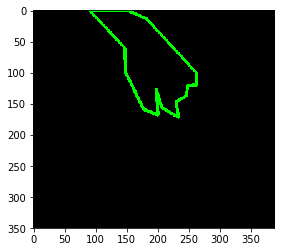

In [15]:
plt.imshow(both.polygonal_image)

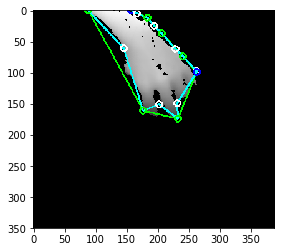

In [16]:
plt.imshow(both.H_detected_defect)

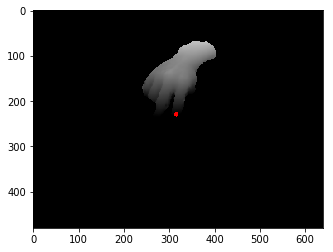

In [17]:
plt.imshow(both.D_finger_point_image)

In [107]:
plt.imshow(both.H_finger_point_image)

In [7]:
reload(HandShapeAnalysis)
camera = HandShapeAnalysis.Depth2Finger(pcl_center, trans_matrix)
camera.set_show(debug=True,finger_point_image=True, hull_image=True, detected_defect=True, cluster_point=True, possibility_modal=False)
camera.RANSAC = True
camera_area, camera_point = camera.renew_depth(depth_frame[13], True)
print(camera_area)
print(camera_point)

TypeError: renew_depth() takes 2 positional arguments but 3 were given

In [181]:
reload(HandShapeAnalysis)
bird = HandShapeAnalysis.Depth2Finger(pcl_center, trans_matrix)
bird.set_show(debug=True,finger_point_image=True, hull_image=True, detected_defect=True, cluster_point=True, possibility_modal=False)
bird.RANSAC = True
high_area, high_point = bird.renew_high(depth_frame[13], True)
print(high_area)
print(high_point)
# plt.imshow(bird.process_image)

TypeError: renew_high() takes 2 positional arguments but 3 were given

In [182]:
high_area

NameError: name 'high_area' is not defined

Camera & bird’s eyes image

In [657]:
plt.imshow(camera.realimage)

AttributeError: 'Depth2Finger' object has no attribute 'realimage'

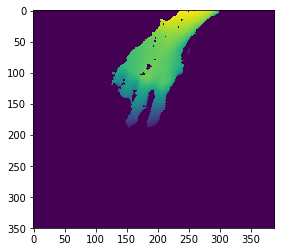

In [603]:
plt.imshow(bird.realimage)

image denoising

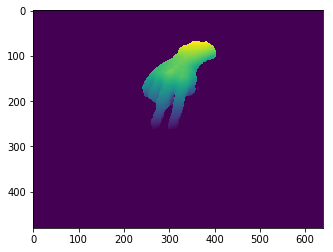

In [604]:
plt.imshow(camera.process_image)

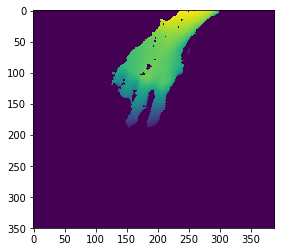

In [605]:
plt.imshow(bird.process_image)

Contours

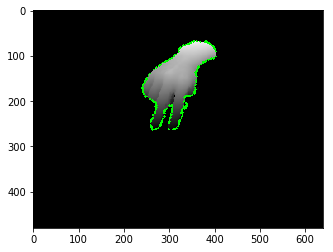

In [606]:
plt.imshow(camera.Contours)

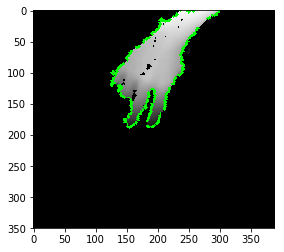

In [607]:
plt.imshow(bird.Contours)

find Convex Hull

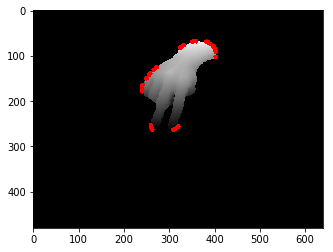

In [608]:
plt.imshow(camera.hull_image)

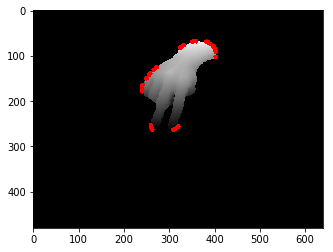

In [609]:
plt.imshow(camera.hull_image)

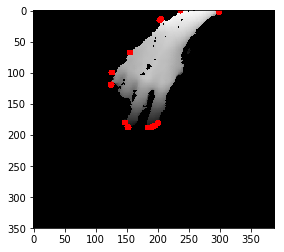

In [610]:
plt.imshow(bird.hull_image)

Cluster hull point

TypeError: Image data cannot be converted to float

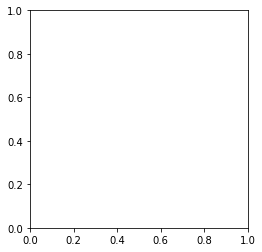

In [655]:
plt.imshow(camera.cluster_point)

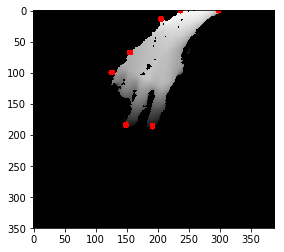

In [654]:
plt.imshow(bird.cluster_point)

detected_defect

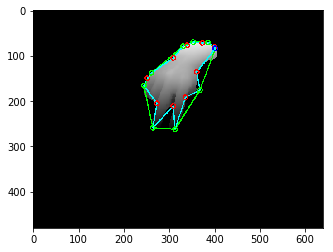

In [522]:
plt.imshow(camera.detected_defect)

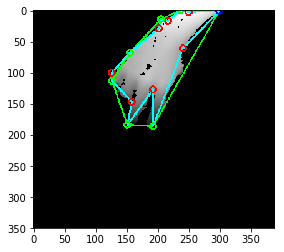

In [523]:
plt.imshow(bird.detected_defect)

finger_point_image

TypeError: Image data cannot be converted to float

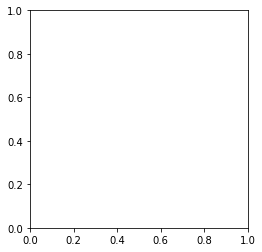

In [656]:
plt.imshow(camera.finger_point_image)

In [473]:
camera_point

array([0.00544115, 0.00772504], dtype=float32)

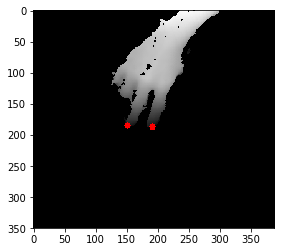

In [642]:
plt.imshow(bird.finger_point_image)

In [475]:
high_point

array([[0.51669168, 0.54777527, 0.00583549],
       [0.61954182, 0.54119313, 0.01001446]])

In [478]:
for c in camera_point:
    for h in high_point:
        print(np.linalg.norm(c-h))

0.7453211117232726
0.8149667065914681
0.7420949100624703
0.8117346908702051
